# Your First Neural Network

In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## DataPreparer

In [2]:
class DataPreparer:
        
    def prepare_data(self, data_path):
        rides = self.load_data(data_path)
        self.log_loaded_data(rides)
        
        data = self.format_data(rides)
        self.log_formatted_data(data)
        
        scaled_features = self.scale_data(data)
        self.log_scaled_data()

        return rides, data, scaled_features
    
    def load_data(self, data_path):
        return pd.read_csv(data_path)
    
    def format_data(self, rides):
        dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
        
        for each in dummy_fields:
            dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
            rides = pd.concat([rides, dummies], axis=1)
            
        fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                          'weekday', 'atemp', 'mnth', 'workingday', 'hr']
        
        return rides.drop(fields_to_drop, axis=1)
    
    def scale_data(self, data):
        quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
        scaled_features = {}
        
        for each in quant_features:
            mean, std = data[each].mean(), data[each].std()
            scaled_features[each] = [mean, std]
            data.loc[:, each] = (data[each] - mean)/std
        
        return scaled_features
    
    def log_loaded_data(self, rides):
        print("Loaded data\n")
        print(rides.head())
        rides[:24*10].plot(x='dteday', y='cnt')
    
    def log_formatted_data(self, data):
        print("\nFormatted data\n")
        print(data.head())
        
    def log_scaled_data(self):
        print("\nScaled data\n")

## DatasetCreator

In [3]:
class DatasetCreator:
    
    def create_datasets(self, data):
        # Save data for approximately the last 21 days 
        test_data = data[-21*24:]
        
        # Now remove the test data from the data set
        data = data[:-21*24]

        # Separate the data into features and targets
        target_fields = ['cnt', 'casual', 'registered']
        features, targets = data.drop(target_fields, axis=1), data[target_fields]
        test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

        # Hold out the last 60 days or so of the remaining data as a validation set
        train_features, train_targets = features[:-60*24], targets[:-60*24]
        val_features, val_targets = features[-60*24:], targets[-60*24:]
        
        return train_features, train_targets, \
               val_features, val_targets, \
               test_features, test_targets, test_data

## NeuralNetwork

In [4]:
class NeuralNetwork(object):
    
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        
        self.lr = learning_rate
        
        #### Set self.activation_function to your implemented sigmoid function ####
        self.activation_function = lambda x : self.sigmoid(x)
        
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Forward pass ####
        
        # Hidden layer
        hidden_inputs = np.dot(features, self.weights_input_to_hidden)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # Output layer
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output)
        final_outputs = final_inputs

        return final_outputs
    
    def sigmoid(self, x):
        ''' Calculate sigmoid '''
        return 1 / (1 + np.exp(-x))

## NetworkTrainer

In [5]:
class NetworkTrainer:
    
    def train_neural_network(self, 
                             network, 
                             train_features, train_targets, 
                             val_features, val_targets,
                             iterations=1000):
        
        losses = {'train':[], 'validation':[]}

        for ii in range(iterations):
            # Go through a random batch of 128 records from the training data set
            batch = np.random.choice(train_features.index, size=128)
            X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']
            
            self.train(network, X, y)

            # Printing out the training progress
            train_loss = self.MSE(network.run(train_features).T, train_targets['cnt'].values)
            val_loss = self.MSE(network.run(val_features).T, val_targets['cnt'].values)
            
            sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                             + "% ... Training loss: " + str(train_loss)[:5] \
                             + " ... Validation loss: " + str(val_loss)[:5])
            sys.stdout.flush()

            losses['train'].append(train_loss)
            losses['validation'].append(val_loss)

        return losses    
    
    def train(self, network, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        '''
        n_records = features.shape[0]
        
        delta_weights_i_h = np.zeros(network.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(network.weights_hidden_to_output.shape)
        
        for X, y in zip(features, targets):
            ### Forward pass ###
            
            # Hidden layer
            hidden_inputs = np.dot(X, network.weights_input_to_hidden)
            hidden_outputs = network.activation_function(hidden_inputs)
        
            # Output layer
            final_inputs = np.dot(hidden_outputs, network.weights_hidden_to_output)
            final_outputs = final_inputs # f(x) = x in regression
            
            ### Backward pass ###

            # Output error
            output_error = y - final_outputs
            output_error_term = output_error # f'(x) = 1
            
            # Hidden layer's contribution to the error
            hidden_error = np.dot(network.weights_hidden_to_output, output_error_term)
            hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)
            
            # Weight step (input to hidden)
            delta_weights_i_h += X[:,None] * hidden_error_term
            # Weight step (hidden to output)
            delta_weights_h_o += hidden_outputs[:,None] * output_error_term

        # Update the weights
        network.weights_hidden_to_output += network.lr * delta_weights_h_o / n_records
        network.weights_input_to_hidden += network.lr * delta_weights_i_h / n_records
    
    def MSE(self, y, Y):
        return np.mean((y-Y)**2)

## ResultVisualizer

In [6]:
class ResultVisualizer:
    
    def plot_losses(self, losses):
        plt.plot(losses['train'], label='Training loss')
        plt.plot(losses['validation'], label='Validation loss')
        plt.legend()
        _ = plt.ylim()
        
    def check_predictions(self, 
                          network, 
                          test_features, test_targets, test_data, 
                          rides, scaled_features):
        
        fig, ax = plt.subplots(figsize=(8,4))

        mean, std = scaled_features['cnt']
        predictions = network.run(test_features).T*std + mean
        ax.plot(predictions[0], label='Prediction')
        ax.plot((test_targets['cnt']*std + mean).values, label='Data')
        ax.set_xlim(right=len(predictions))
        ax.legend()

        dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
        dates = dates.apply(lambda d: d.strftime('%b %d'))
        ax.set_xticks(np.arange(len(dates))[12::24])
        _ = ax.set_xticklabels(dates[12::24], rotation=45)

# FirstNN

In [7]:
class FirstNN:
    
    def __init__(self):
        self.data_path = 'Bike-Sharing-Dataset/hour.csv'
        
    def get_data(self):
        print("DATA PREPARATION STEP\n")
        dataPreparer = DataPreparer()
        self.rides, self.data, self.scaled_features = dataPreparer.prepare_data(self.data_path)
        print("DATA PREPARATION COMPLETE\n")
        
    def create_datasets(self):
        print("DATASET CREATION STEP\n")
        datasetCreator = DatasetCreator()
        self.train_features, self.train_targets, \
            self.val_features, self.val_targets, \
            self.test_features, self.test_targets, self.test_data = \
            datasetCreator.create_datasets(self.data)
        print("DATASET CREATION COMPLETE\n")

    def set_hyperparameters(self):
        print("HYPERPARAMETER SETTING STEP\n")
        self.input_nodes = self.train_features.shape[1]
        self.hidden_nodes = 30
        self.output_nodes = 1
        self.learning_rate = 0.5
        self.iterations = 5000
        print("HYPERPARAMETER SETTING COMPLETE\n")
    
    def build_network(self):
        print("NETWORK BUILDING STEP\n")
        self.network = NeuralNetwork(self.input_nodes, 
                                     self.hidden_nodes, 
                                     self.output_nodes, 
                                     self.learning_rate)
        print("NETWORK BUILDING COMPLETE\n")
        
    def train_network(self):
        print("NETWORK TRAINING STEP\n")
        networkTrainer = NetworkTrainer()
        self.losses = networkTrainer.train_neural_network(self.network,
                                                          self.train_features, self.train_targets,
                                                          self.val_features, self.val_targets,
                                                          self.iterations)
        print("\n\nNETWORK TRAINING COMPLETE\n")
        
    def visualize_results(self):
        print("VISUALIZATION STEP\n")
        visualizer = ResultVisualizer()
        visualizer.plot_losses(self.losses)
        visualizer.check_predictions(self.network,
                                     self.test_features, self.test_targets, self.test_data,
                                     self.rides, self.scaled_features)
        print("VISUALIZATION COMPLETE\n")

In [8]:
nn = FirstNN()

DATA PREPARATION STEP

Loaded data

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  

Formatted data

   yr  holiday  temp   hum  windspeed  casual 

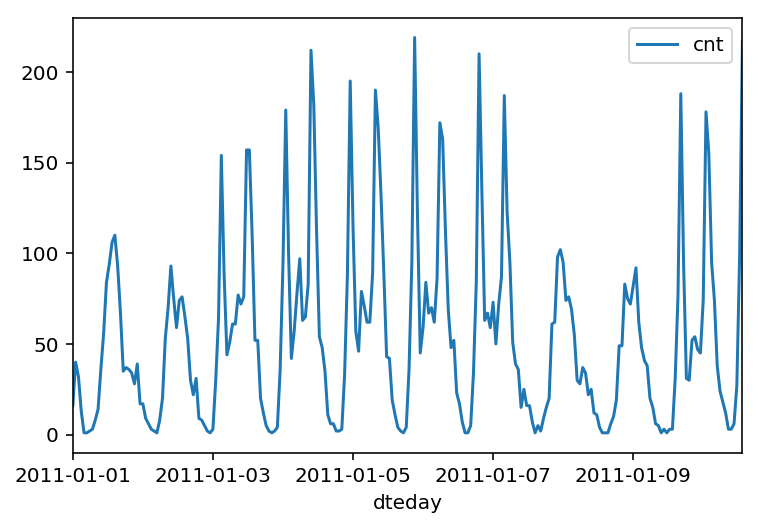

In [9]:
nn.get_data()

In [10]:
nn.create_datasets()

DATASET CREATION STEP

DATASET CREATION COMPLETE



In [11]:
nn.set_hyperparameters()

HYPERPARAMETER SETTING STEP

HYPERPARAMETER SETTING COMPLETE



In [12]:
nn.build_network()

NETWORK BUILDING STEP

NETWORK BUILDING COMPLETE



In [13]:
nn.train_network()

NETWORK TRAINING STEP

Progress: 100.0% ... Training loss: 0.075 ... Validation loss: 0.176

NETWORK TRAINING COMPLETE



VISUALIZATION STEP

VISUALIZATION COMPLETE



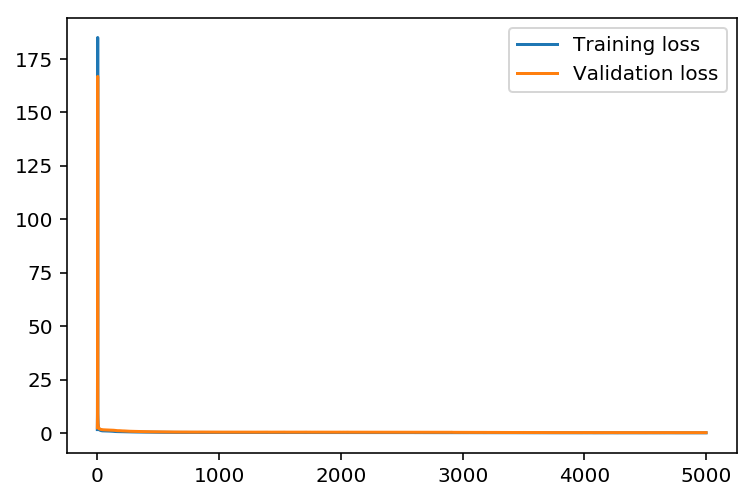

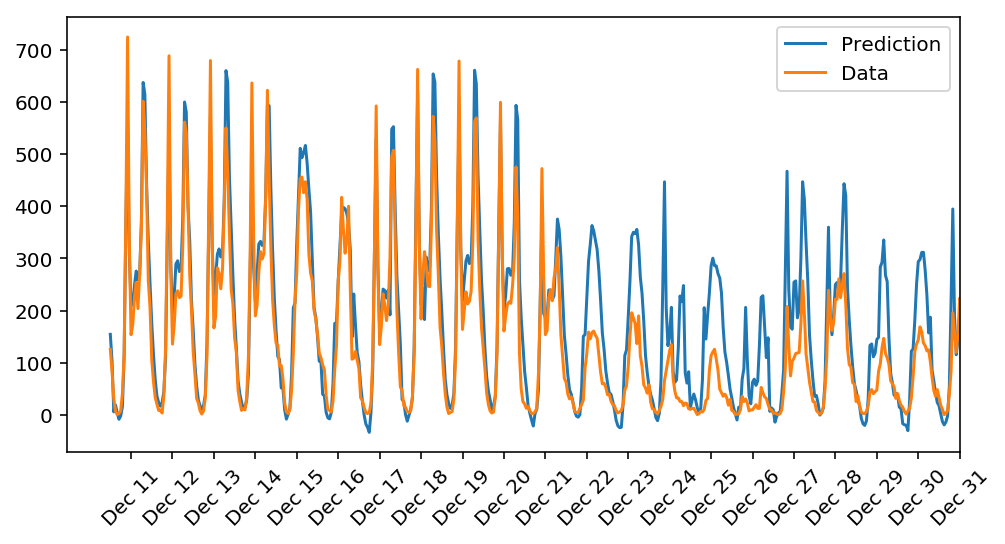

In [14]:
nn.visualize_results()